In [1]:
import torch
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import PIL
import cv2 as cv
import tensorflow as tf
from keras.preprocessing import image
from keras.models import load_model
import keras.optimizers
import numpy as np

# from glob import glob
import matplotlib.pyplot as plt
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

class_labels = [
    "combat",
    "destroyedbuilding",
    "empty",
    "fire",
    "humanitarianaid",
    "militaryvehicles",
]
IMG_SIZE = (160, 160)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


/home/srikar/miniconda3/envs/GG_1240/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-02-19 18:52:13.182863: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 18:52:13.220544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 18:52:13.220586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plug

cpu


In [6]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def preprocess_and_display(image_path):
    img = Image.open(image_path)
    input_tensor = transform(img)
    input_batch = input_tensor.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)

    if display:
        numpy_img = input_tensor.permute(1, 2, 0).numpy()
        numpy_img = cv.cvtColor(numpy_img, cv.COLOR_BGR2RGB)
        cv.imshow("Preprocessed Image", numpy_img)
        cv.waitKey(200)
        cv.destroyAllWindows()

    return input_batch


In [2]:
train_data_dir = "/mnt/Storage/Dataset/Final_Dataset/Train_Set"
test_data_dir = "/mnt/Storage/Dataset/Final_Dataset/Test_Set"
val_dir = "/mnt/Storage/Dataset/Final_Dataset/Validation_Set/"
model_dir = "/mnt/Storage/Dataset/Yolo-cls/model_HC2.h5"


In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.02,
    zoom_range=0.01,
    horizontal_flip=1,
    brightness_range=(0.1, 1.9),
    fill_mode="constant",
    cval=255,
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.02,
    zoom_range=0.01,
    horizontal_flip=1,
    brightness_range=(0.1, 1.9),
    fill_mode="constant",
    cval=255,
    preprocessing_function=preprocess_input,
)


In [9]:
print(keras.__version__)
print(tf.__version__)


2.15.0
2.15.0


In [10]:
# Define constants
NUM_CLASSES = 6
BATCH_SIZE = 32
EPOCHS = 1
LR = 0.001

TRAIN_DIR = train_data_dir
TEST_DIR = test_data_dir

base_model = ResNet50V2(
    weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,)
)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dropout(0.5))  # Add dropout after the pooling layer
model.add(
    Dense(NUM_CLASSES, activation="softmax", kernel_regularizer=l2(0.01))
)  # Add L2 regularization to the Dense layer
optim = keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=["accuracy"])

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)


metric = "accuracy"
checkpoint = ModelCheckpoint(
    filepath=model_dir,
    monitor=metric,
    verbose=2,
    save_best_only=True,
    mode="max",
)
early_stopping = EarlyStopping(monitor="val_loss", patience=4)

callbacks = [checkpoint]

start = datetime.now()

model_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(os.listdir(train_data_dir)) // BATCH_SIZE,
    validation_steps=len(os.listdir(test_data_dir)) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=2,
)
duration = datetime.now() - start
print("Training completed in time: ", duration)


Found 2346 images belonging to 6 classes.
Found 396 images belonging to 6 classes.


ValueError: Unexpected value for `steps_per_epoch`. Received value is 0. Please check the docstring for `model.fit()` for supported values.

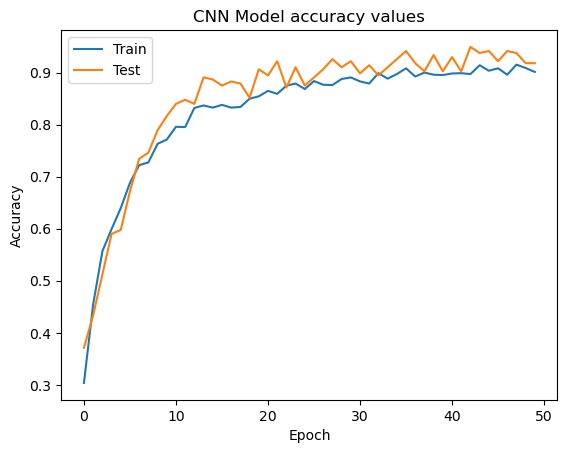

In [ ]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("CNN Model accuracy values")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()


In [12]:
loaded_model = load_model(model_dir)
print(loaded_model.summary())
class_labels = [
    "combat",
    "destroyedbuilding",
    "empty",
    "fire",
    "humanitarianaid",
    "militaryvehicles",
]
result_list = []
for classes in os.listdir(val_dir):
    total_images = 0
    correct = 0
    for images in os.listdir(val_dir + "/" + classes):
        img_path = val_dir + "/" + classes + "/" + images
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        probabilities = loaded_model.predict(img_array)
        predicted_class_index = np.argmax(probabilities)
        pred = class_labels[predicted_class_index]
        if (classes) == pred:
            correct += 1
        total_images += 1
    result_list.append(
        str(
            str(correct)
            + "/"
            + str(total_images)
            + "    "
            + str(round((correct / total_images) * 100))
            + "%   --> "
            + classes
        )
    )
for i in result_list:
    print(i)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23577094 (89.94 MB)
Trainable params: 12294 (48.02 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________
None
1/1 [==============================] - 0s 67ms/step


In [ ]:
# loaded_model = load_model("/mnt/Storage/Dataset/model_HC.h5")
# loaded_model = load_model(model_dir)
# # print(loaded_model.summary())
# event_arcs = [21, 29, 30, 34, 48]
# img = image.load_img(
#     "/mnt/Storage/Downloads/Event_48.jpg",
#     target_size=IMG_SIZE,
# )
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)
# probabilities = loaded_model.predict(img_array)
# predicted_class_index = np.argmax(probabilities)
# pred = class_labels[predicted_class_index]
# print(pred)


1/1 [==============================] - 1s 750ms/step
destroyedbuilding
